In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
from importlib import reload
import os
import matplotlib.pyplot as plt

2024-12-07 13:18:31.073274: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-07 13:18:31.073306: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
!export CUDA_VISIBLE_DEVICES=""

In [3]:
from magenta.models.rl_tuner import rl_tuner, rl_tuner_ops, rl_tuner_per
from magenta.contrib import training as contrib_training

/home/vinkovskiy/.local/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/vinkovskiy/.local/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [4]:
# Keep default RNN params for all experiments
hparams = rl_tuner_ops.default_hparams()

## Helpers

In [5]:
def plot_rewards(rl_net):
  reward_batch = rl_net.output_every_nth
  x = np.array([reward_batch * i for i in np.arange(len(rl_net.eval_avg_reward))])
  start_index = 0 # / self.output_every_nth
  plt.figure()
  plt.plot(x, rl_net.eval_avg_reward)
  plt.plot(x, rl_net.eval_avg_music_theory_reward)
  plt.plot(x, rl_net.eval_avg_note_rnn_reward)
  plt.xlabel('Training epoch')
  plt.ylabel('Average reward')
  plt.legend(['Total', 'Music theory', 'Note RNN'], loc='best')
  plt.show()

In [6]:
def reload_model():
  reload(rl_tuner_ops)
  reload(rl_tuner)
  rl_tuner.reload_files()

## Default hyperparmaters

In [7]:
output_dir = "/tmp/rl_tuner/"
save_dir = "/home/vinkovskiy/magenta/magenta/saved_models/"
note_rnn_checkpoint_dir = '/home/vinkovskiy/magenta/magenta/note_rnn_checkpoints'
note_rnn_checkpoint_name = 'note_rnn.ckpt'
note_rnn_type = 'default'
training_steps = 1000000
exploration_steps = 500000
exploration_mode = 'egreedy'
output_every_nth = 50000
num_notes_in_melody = 32
reward_scaler = 2
midi_primer = '/home/vinkovskiy/magenta/magenta/magenta/testdata/primer.mid'
algorithm = 'psi'
output_ckpt = algorithm + ".ckpt"
backup_checkpoint_file = os.path.join(note_rnn_checkpoint_dir, note_rnn_checkpoint_name)

In [8]:
dqn_hparams = contrib_training.HParams(
      random_action_probability=0.1,
      store_every_nth=1,
      train_every_nth=5,
      minibatch_size=32,
      discount_rate=0.5,
      max_experience=100000,
      target_network_update_rate=0.01)

## Train network

### Optimal configuration from the paper

In [62]:
rl_net = rl_tuner.RLTuner(output_dir=output_dir,
                          midi_primer=midi_primer,
                          dqn_hparams=dqn_hparams,
                          reward_scaler=reward_scaler,
                          save_name=output_ckpt,
                          output_every_nth=output_every_nth,
                          note_rnn_checkpoint_dir=note_rnn_checkpoint_dir,
                          note_rnn_checkpoint_file=backup_checkpoint_file,
                          note_rnn_type=note_rnn_type,
                          note_rnn_hparams=hparams,
                          num_notes_in_melody=num_notes_in_melody,
                          exploration_mode=exploration_mode,
                          algorithm=algorithm)

INFO:tensorflow:Initializing q network
INFO:tensorflow:Using custom hparams
INFO:tensorflow:Initializing melody RNN graph for scope q_network
INFO:tensorflow:Initializing target q network
INFO:tensorflow:Using custom hparams
INFO:tensorflow:Initializing melody RNN graph for scope target_q_network
INFO:tensorflow:Initializing reward network
INFO:tensorflow:Using custom hparams
INFO:tensorflow:Initializing melody RNN graph for scope reward_rnn
INFO:tensorflow:Q network cell: <keras.layers.rnn.legacy_cells.MultiRNNCell object at 0x72d5fa2bc4d0>
INFO:tensorflow:Adding RL graph variables
INFO:tensorflow:Adding reward computation portion of the graph
INFO:tensorflow:Adding taking action portion of graph
INFO:tensorflow:Add estimating future rewards portion of graph
INFO:tensorflow:Adding q value prediction portion of graph
INFO:tensorflow:Summary name q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel:0 is illegal; using q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel_0 instead.
INFO:

INFO:tensorflow:Priming with note 27
INFO:tensorflow:Generated sequence: [0, 0, 1, 26, 0, 30, 26, 0, 26, 0, 1, 19, 19, 21, 0, 1, 26, 28, 33, 1, 26, 0, 30, 26, 0, 23, 26, 0, 1, 0, 23, 25]
Generated sequence: [0, 0, 1, 26, 0, 30, 26, 0, 26, 0, 1, 19, 19, 21, 0, 1, 26, 28, 33, 1, 26, 0, 30, 26, 0, 23, 26, 0, 1, 0, 23, 25]
INFO:tensorflow:Wrote a melody to /tmp/rl_tuner/
INFO:tensorflow:Visualizing note selection probabilities:


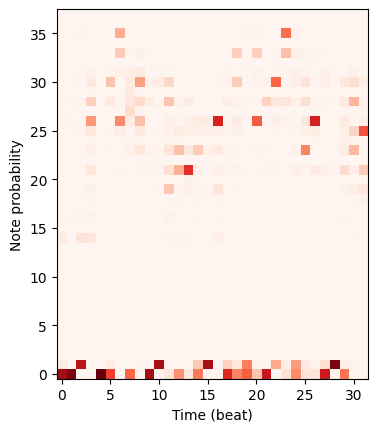

In [27]:
# Generate initial music sequence before training with RL
rl_net.generate_music_sequence(visualize_probs=True, title='pre_op', length=32)

In [24]:
rl_net.train(num_steps=1000000, exploration_period=500000)

INFO:tensorflow:Evaluating initial model...
INFO:tensorflow:Evaluating model...
INFO:tensorflow:/tmp/rl_tuner/psi-0.npz
INFO:tensorflow:0
INFO:tensorflow:/tmp/rl_tuner/psi-0.data-00000-of-00001
INFO:tensorflow:1200
INFO:tensorflow:/tmp/rl_tuner/psi-0.meta
INFO:tensorflow:1700
INFO:tensorflow:/tmp/rl_tuner/psi-0.index
INFO:tensorflow:1700
INFO:tensorflow:/tmp/rl_tuner/psi.ckpt-50000.data-00000-of-00001
INFO:tensorflow:1200
INFO:tensorflow:/tmp/rl_tuner/psi.ckpt-50000.index
INFO:tensorflow:1200
INFO:tensorflow:/tmp/rl_tuner/psi.ckpt-50000.meta
INFO:tensorflow:1700
INFO:tensorflow:Training iteration 50000
INFO:tensorflow:	Reward for last 50000 steps: -293931.0142720118
INFO:tensorflow:		Music theory reward: -40949.32201781919
INFO:tensorflow:		Note RNN reward: -252981.69225418568
Training iteration 50000
	Reward for last 50000 steps: -293931.0142720118
		Music theory reward: -40949.32201781919
		Note RNN reward: -252981.69225418568
INFO:tensorflow:	Exploration probability is 0.9042382
INF

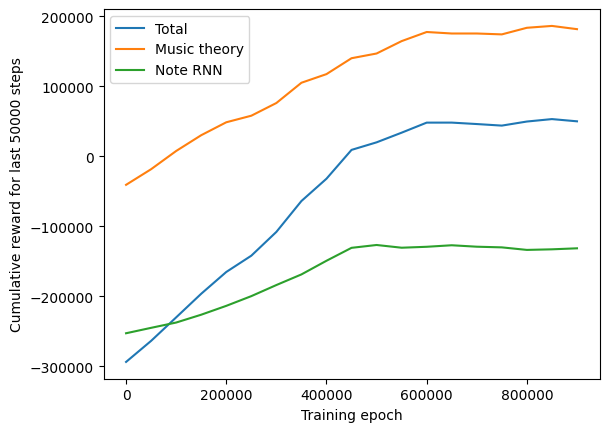

In [25]:
rl_net.plot_rewards()

INFO:tensorflow:Priming with note 33
INFO:tensorflow:Generated sequence: [0, 0, 1, 30, 0, 0, 1, 31, 30, 28, 26, 0, 28, 26, 31, 0, 33, 33, 1, 26, 28, 33, 1, 33, 1, 26, 28, 33, 1, 26, 0, 33]
Generated sequence: [0, 0, 1, 30, 0, 0, 1, 31, 30, 28, 26, 0, 28, 26, 31, 0, 33, 33, 1, 26, 28, 33, 1, 33, 1, 26, 28, 33, 1, 26, 0, 33]
INFO:tensorflow:Wrote a melody to /tmp/rl_tuner/
INFO:tensorflow:Visualizing note selection probabilities:


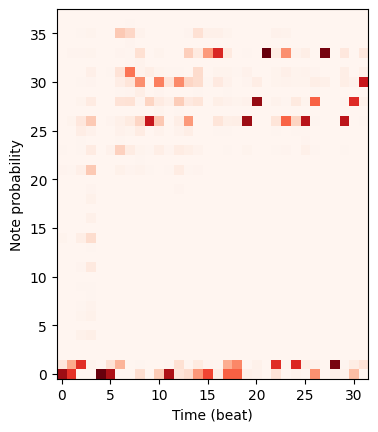

In [46]:
rl_net.generate_music_sequence(visualize_probs=True, title='post_op', length=32)

In [49]:
# Save model
rl_net.save_model(save_dir, 'psi_paper')

INFO:tensorflow:/home/vinkovskiy/magenta/magenta/saved_models/-950000.meta
INFO:tensorflow:500
INFO:tensorflow:/home/vinkovskiy/magenta/magenta/saved_models/-950000.data-00000-of-00001
INFO:tensorflow:1700
INFO:tensorflow:/home/vinkovskiy/magenta/magenta/saved_models/-950000.index
INFO:tensorflow:1700


In [50]:
# Compute statistics about how well the model adheres to the music theory rules.
stat_dict = rl_net.evaluate_music_theory_metrics(num_compositions=100)

INFO:tensorflow:Total compositions: 100.0
Total notes:3200.0
	Compositions starting with tonic: 17.0
	Compositions with unique highest note:51.0
	Compositions with unique lowest note:65.0
	Number of resolved leaps:105.0
	Number of double leaps:8.0
	Notes not in key:24.0
	Notes in motif:2338.0
	Notes in repeated motif:3.0
	Notes excessively repeated:0.0

	Percent compositions starting with tonic:0.17
	Percent compositions with unique highest note:0.51
	Percent compositions with unique lowest note:0.65
	Percent of leaps resolved:0.9292035398230089
	Percent notes not in key:0.0075
	Percent notes in motif:0.730625
	Percent notes in repeated motif:0.0009375
	Percent notes excessively repeated:0.0

	Average autocorrelation of lag1:-0.12983339080518572
	Average autocorrelation of lag2:-0.022261393440448352
	Average autocorrelation of lag3:-0.012954999924002574

	Avg. num octave jumps per composition:0.01
	Avg. num sevenths per composition:0.02
	Avg. num fifths per composition:0.15
	Avg. num s

## Prioritized Experience Replay (PER)

### Paper Parameters

In [13]:
reload_model()

In [9]:
per_rl_net = rl_tuner_per.RLTunerPER(output_dir=output_dir,
                                    midi_primer=midi_primer,
                                    dqn_hparams=dqn_hparams,
                                    reward_scaler=reward_scaler,
                                    save_name=output_ckpt,
                                    output_every_nth=output_every_nth,
                                    note_rnn_checkpoint_dir=note_rnn_checkpoint_dir,
                                    note_rnn_checkpoint_file=backup_checkpoint_file,
                                    note_rnn_type=note_rnn_type,
                                    note_rnn_hparams=hparams,
                                    num_notes_in_melody=num_notes_in_melody,
                                    exploration_mode=exploration_mode,
                                    algorithm=algorithm)

INFO:tensorflow:Initializing q network
INFO:tensorflow:Using custom hparams
INFO:tensorflow:Initializing melody RNN graph for scope q_network
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Initializing target q network
INFO:tensorflow:Using custom hparams
INFO:tensorflow:Initializing melody RNN graph for scope target_q_network
INFO:tensorflow:Initializing reward network
INFO:tensorflow:Using custom hparams
INFO:tensorflow:Initializing melody RNN graph for scope reward_rnn


/home/vinkovskiy/magenta/magenta/magenta/models/rl_tuner/rl_tuner_ops.py:310: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.nn.rnn_cell.LSTMCell(num_units, state_is_tuple=state_is_tuple)


INFO:tensorflow:Q network cell: <keras.layers.rnn.legacy_cells.MultiRNNCell object at 0x7ad8d5090f90>
INFO:tensorflow:Adding RL graph variables
INFO:tensorflow:Adding reward computation portion of the graph
INFO:tensorflow:Adding taking action portion of graph
Instructions for updating:
Use the `axis` argument instead
INFO:tensorflow:Add estimating future rewards portion of graph
INFO:tensorflow:Adding q value prediction portion of graph
INFO:tensorflow:Summary name q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel:0 is illegal; using q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel_0 instead.
INFO:tensorflow:Summary name q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel:0/gradients is illegal; using q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel_0/gradients instead.
INFO:tensorflow:Summary name q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/bias:0 is illegal; using q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/bias_0 instead.
INFO:tensorflow:Summary name q_network/rnn/m

2024-12-07 13:18:42.776285: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-12-07 13:18:42.776319: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-12-07 13:18:42.776336: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Ubuntu-VM): /proc/driver/nvidia/version does not exist
2024-12-07 13:18:42.776550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-07 13:18:42.793699: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization 


Successfully initialized internal nets from checkpoint!
INFO:tensorflow:
Successfully initialized internal nets from checkpoint!


INFO:tensorflow:Priming with note 5
INFO:tensorflow:Generated sequence: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 16, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 21, 0, 14]
Generated sequence: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 16, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 21, 0, 14]
INFO:tensorflow:Wrote a melody to /tmp/rl_tuner/
INFO:tensorflow:Visualizing note selection probabilities:


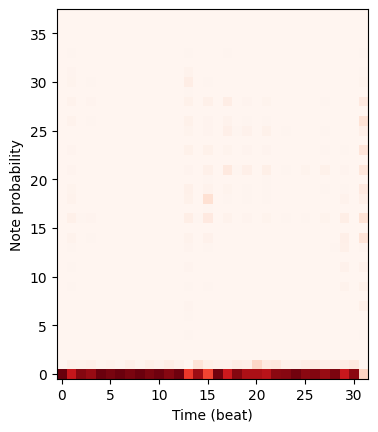

In [10]:
per_rl_net.generate_music_sequence(visualize_probs=True, title='pre_op', length=32)

In [11]:
per_rl_net.train(num_steps=1000000, exploration_period=500000)

INFO:tensorflow:Evaluating initial model...


/home/vinkovskiy/magenta/magenta/magenta/models/rl_tuner/rl_tuner_ops.py:138: RuntimeWarning: invalid value encountered in double_scalars
  return (x[lag:] * x[:n - lag]).sum() / float(n) / c0


INFO:tensorflow:Evaluating model...
INFO:tensorflow:/tmp/rl_tuner/psi-0.npz
INFO:tensorflow:0
INFO:tensorflow:/tmp/rl_tuner/psi-0.data-00000-of-00001
INFO:tensorflow:1200
INFO:tensorflow:/tmp/rl_tuner/psi-0.meta
INFO:tensorflow:1700
INFO:tensorflow:/tmp/rl_tuner/psi-0.index
INFO:tensorflow:1700
INFO:tensorflow:/tmp/rl_tuner/psi.ckpt-50000.data-00000-of-00001
INFO:tensorflow:1200
INFO:tensorflow:/tmp/rl_tuner/psi.ckpt-50000.index
INFO:tensorflow:1200
INFO:tensorflow:/tmp/rl_tuner/psi.ckpt-50000.meta
INFO:tensorflow:1700
INFO:tensorflow:Training iteration 50000
INFO:tensorflow:	Reward for last 50000 steps: -289735.61549911497
INFO:tensorflow:		Music theory reward: -37070.48830696825
INFO:tensorflow:		Note RNN reward: -252665.12719213963
Training iteration 50000
	Reward for last 50000 steps: -289735.61549911497
		Music theory reward: -37070.48830696825
		Note RNN reward: -252665.12719213963
INFO:tensorflow:	Exploration probability is 0.9042382
INFO:tensorflow:Evaluating model...
INFO:tens

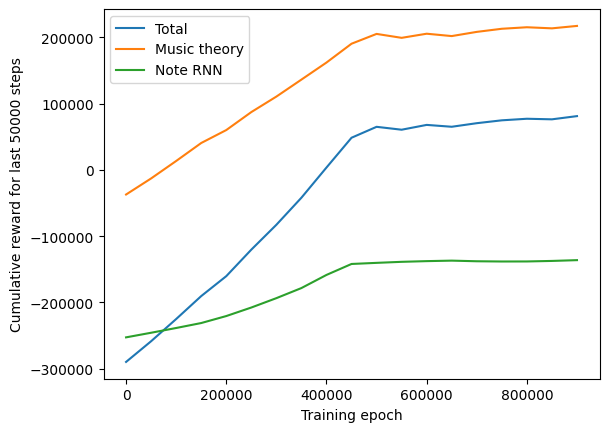

In [12]:
per_rl_net.plot_rewards()

INFO:tensorflow:Priming with note 23
INFO:tensorflow:Generated sequence: [0, 0, 1, 16, 0, 1, 16, 18, 21, 1, 21, 1, 23, 27, 28, 30, 1, 26, 1, 31, 33, 1, 0, 26, 1, 30, 33, 31, 33, 1, 0, 0]
Generated sequence: [0, 0, 1, 16, 0, 1, 16, 18, 21, 1, 21, 1, 23, 27, 28, 30, 1, 26, 1, 31, 33, 1, 0, 26, 1, 30, 33, 31, 33, 1, 0, 0]
INFO:tensorflow:Wrote a melody to /tmp/rl_tuner/
INFO:tensorflow:Visualizing note selection probabilities:


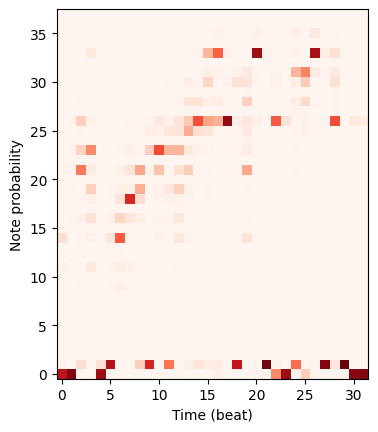

In [24]:
per_rl_net.generate_music_sequence(visualize_probs=True, title='post_per', length=32)

In [20]:
per_rl_net.save_model(os.path.join(save_dir, "psi_per"), 'psi_per')

INFO:tensorflow:/home/vinkovskiy/magenta/magenta/saved_models/psi_per-950000.meta
INFO:tensorflow:500
INFO:tensorflow:/home/vinkovskiy/magenta/magenta/saved_models/psi_per-950000.index
INFO:tensorflow:500
INFO:tensorflow:/home/vinkovskiy/magenta/magenta/saved_models/psi_per-950000.data-00000-of-00001
INFO:tensorflow:1700


In [22]:
stat_dict = per_rl_net.evaluate_music_theory_metrics(num_compositions=100)

INFO:tensorflow:Total compositions: 100.0
Total notes:3200.0
	Compositions starting with tonic: 22.0
	Compositions with unique highest note:53.0
	Compositions with unique lowest note:50.0
	Number of resolved leaps:86.0
	Number of double leaps:15.0
	Notes not in key:36.0
	Notes in motif:2416.0
	Notes in repeated motif:0.0
	Notes excessively repeated:0.0

	Percent compositions starting with tonic:0.22
	Percent compositions with unique highest note:0.53
	Percent compositions with unique lowest note:0.5
	Percent of leaps resolved:0.8514851485148515
	Percent notes not in key:0.01125
	Percent notes in motif:0.755
	Percent notes in repeated motif:0.0
	Percent notes excessively repeated:0.0

	Average autocorrelation of lag1:-0.07073999880745094
	Average autocorrelation of lag2:0.03745226356918968
	Average autocorrelation of lag3:-0.04450342712664649

	Avg. num octave jumps per composition:0.0
	Avg. num sevenths per composition:0.02
	Avg. num fifths per composition:0.15
	Avg. num sixths per com

### Increased exploration

In [25]:
dqn_hparams_1 = contrib_training.HParams(
      random_action_probability=0.15,
      store_every_nth=1,
      train_every_nth=5,
      minibatch_size=32,
      discount_rate=0.5,
      max_experience=100000,
      target_network_update_rate=0.01)

In [26]:
per_rl_net_1 = rl_tuner_per.RLTunerPER(output_dir=output_dir,
                                       midi_primer=midi_primer,
                                       dqn_hparams=dqn_hparams_1,
                                       reward_scaler=reward_scaler,
                                       save_name=output_ckpt,
                                       output_every_nth=output_every_nth,
                                       note_rnn_checkpoint_dir=note_rnn_checkpoint_dir,
                                       note_rnn_checkpoint_file=backup_checkpoint_file,
                                       note_rnn_type=note_rnn_type,
                                       note_rnn_hparams=hparams,
                                       num_notes_in_melody=num_notes_in_melody,
                                       exploration_mode=exploration_mode,
                                       algorithm=algorithm)

INFO:tensorflow:Initializing q network
INFO:tensorflow:Using custom hparams
INFO:tensorflow:Initializing melody RNN graph for scope q_network
INFO:tensorflow:Initializing target q network
INFO:tensorflow:Using custom hparams
INFO:tensorflow:Initializing melody RNN graph for scope target_q_network
INFO:tensorflow:Initializing reward network
INFO:tensorflow:Using custom hparams
INFO:tensorflow:Initializing melody RNN graph for scope reward_rnn


/home/vinkovskiy/magenta/magenta/magenta/models/rl_tuner/rl_tuner_ops.py:310: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.nn.rnn_cell.LSTMCell(num_units, state_is_tuple=state_is_tuple)


INFO:tensorflow:Q network cell: <keras.layers.rnn.legacy_cells.MultiRNNCell object at 0x7ad8ddea7890>
INFO:tensorflow:Adding RL graph variables
INFO:tensorflow:Adding reward computation portion of the graph
INFO:tensorflow:Adding taking action portion of graph
INFO:tensorflow:Add estimating future rewards portion of graph
INFO:tensorflow:Adding q value prediction portion of graph
INFO:tensorflow:Summary name q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel:0 is illegal; using q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel_0 instead.
INFO:tensorflow:Summary name q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel:0/gradients is illegal; using q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel_0/gradients instead.
INFO:tensorflow:Summary name q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/bias:0 is illegal; using q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/bias_0 instead.
INFO:tensorflow:Summary name q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/bias:0/gradients is illegal;

INFO:tensorflow:Priming with note 23
INFO:tensorflow:Generated sequence: [0, 0, 21, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Generated sequence: [0, 0, 21, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
INFO:tensorflow:Wrote a melody to /tmp/rl_tuner/
INFO:tensorflow:Visualizing note selection probabilities:


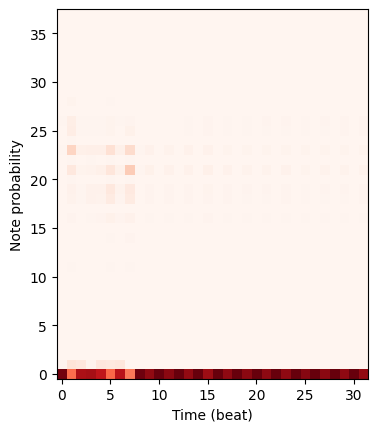

In [28]:
per_rl_net_1.generate_music_sequence(visualize_probs=True, title='pre_per_1', length=32)

In [29]:
per_rl_net_1.train(num_steps=1000000, exploration_period=500000)

INFO:tensorflow:Evaluating initial model...


/home/vinkovskiy/magenta/magenta/magenta/models/rl_tuner/rl_tuner_ops.py:138: RuntimeWarning: invalid value encountered in double_scalars
  return (x[lag:] * x[:n - lag]).sum() / float(n) / c0


INFO:tensorflow:Evaluating model...
INFO:tensorflow:/tmp/rl_tuner/psi-0.npz
INFO:tensorflow:0
INFO:tensorflow:/tmp/rl_tuner/psi-0.data-00000-of-00001
INFO:tensorflow:1200
INFO:tensorflow:/tmp/rl_tuner/psi-0.meta
INFO:tensorflow:1700
INFO:tensorflow:/tmp/rl_tuner/psi-0.index
INFO:tensorflow:1700
INFO:tensorflow:/tmp/rl_tuner/psi.ckpt-50000.data-00000-of-00001
INFO:tensorflow:1200
INFO:tensorflow:/tmp/rl_tuner/psi.ckpt-50000.index
INFO:tensorflow:1200
INFO:tensorflow:/tmp/rl_tuner/psi.ckpt-50000.meta
INFO:tensorflow:1700
INFO:tensorflow:Training iteration 50000
INFO:tensorflow:	Reward for last 50000 steps: -291243.9280283193
INFO:tensorflow:		Music theory reward: -38054.593474114685
INFO:tensorflow:		Note RNN reward: -253189.3345541954
Training iteration 50000
	Reward for last 50000 steps: -291243.9280283193
		Music theory reward: -38054.593474114685
		Note RNN reward: -253189.3345541954
INFO:tensorflow:	Exploration probability is 0.9095583
INFO:tensorflow:Evaluating model...
INFO:tensor

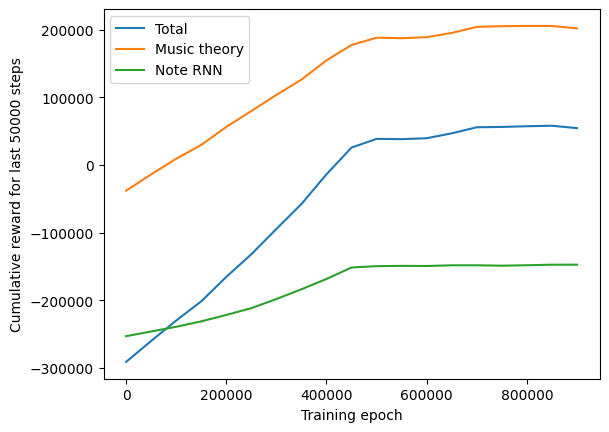

In [41]:
per_rl_net_1.plot_rewards()

INFO:tensorflow:Priming with note 20
INFO:tensorflow:Generated sequence: [0, 0, 1, 21, 1, 23, 21, 14, 1, 0, 19, 0, 25, 30, 26, 1, 21, 1, 14, 1, 18, 21, 14, 1, 16, 18, 21, 0, 1, 26, 25, 23]
Generated sequence: [0, 0, 1, 21, 1, 23, 21, 14, 1, 0, 19, 0, 25, 30, 26, 1, 21, 1, 14, 1, 18, 21, 14, 1, 16, 18, 21, 0, 1, 26, 25, 23]
INFO:tensorflow:Wrote a melody to /tmp/rl_tuner/
INFO:tensorflow:Visualizing note selection probabilities:


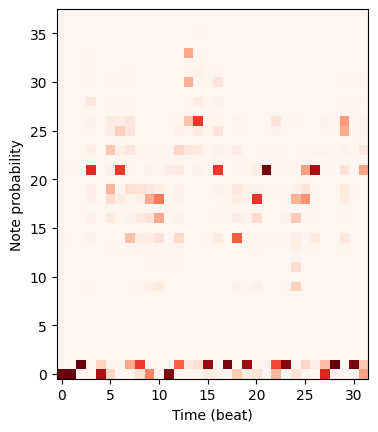

In [40]:
per_rl_net_1.generate_music_sequence(visualize_probs=True, title='post_per_1', length=32)

In [43]:
per_rl_net_1.save_model(os.path.join(save_dir, "psi_per_in_exp"), 'psi_per_in_exp')

INFO:tensorflow:/home/vinkovskiy/magenta/magenta/saved_models/psi_per_in_exp-950000.data-00000-of-00001
INFO:tensorflow:1200
INFO:tensorflow:/home/vinkovskiy/magenta/magenta/saved_models/psi_per_in_exp-950000.npz
INFO:tensorflow:1200
INFO:tensorflow:/home/vinkovskiy/magenta/magenta/saved_models/psi_per_in_exp-950000.meta
INFO:tensorflow:1700
INFO:tensorflow:/home/vinkovskiy/magenta/magenta/saved_models/psi_per_in_exp-950000.index
INFO:tensorflow:1700


In [44]:
stat_dict = per_rl_net_1.evaluate_music_theory_metrics(num_compositions=100)

INFO:tensorflow:Total compositions: 100.0
Total notes:3200.0
	Compositions starting with tonic: 33.0
	Compositions with unique highest note:72.0
	Compositions with unique lowest note:61.0
	Number of resolved leaps:77.0
	Number of double leaps:11.0
	Notes not in key:21.0
	Notes in motif:2383.0
	Notes in repeated motif:0.0
	Notes excessively repeated:0.0

	Percent compositions starting with tonic:0.33
	Percent compositions with unique highest note:0.72
	Percent compositions with unique lowest note:0.61
	Percent of leaps resolved:0.875
	Percent notes not in key:0.0065625
	Percent notes in motif:0.7446875
	Percent notes in repeated motif:0.0
	Percent notes excessively repeated:0.0

	Average autocorrelation of lag1:-0.1063087806656399
	Average autocorrelation of lag2:0.02066757254492557
	Average autocorrelation of lag3:8.191811930016641e-05

	Avg. num octave jumps per composition:0.0
	Avg. num sevenths per composition:0.01
	Avg. num fifths per composition:0.21
	Avg. num sixths per compositi